In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sn 
import h5py

from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras import regularizers
from tensorflow.keras.backend import clear_session
from tensorflow.keras.regularizers import l1
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras.losses import mse
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import decomposition
from numpy import argmax

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report

In [2]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [3]:
filename = '/home/bioml/Projects/PhD/InpactorDB/version_final/InpactorDB_non-redudant.fasta.kmers'
training = pd.read_csv(filename)
training

,Label,A,C,G,T,AA,AC,AG,AT,CA,...,TTTTCG,TTTTCT,TTTTGA,TTTTGC,TTTTGG,TTTTGT,TTTTTA,TTTTTC,TTTTTG,TTTTTT
0,18,2592,1965,1269,1935,933,590,423,646,717,...,3,3,2,1,0,1,1,4,0,0
1,18,2959,2249,1811,2372,1013,596,546,804,863,...,1,1,1,0,0,1,5,0,0,0
2,18,5673,3949,3563,5645,1760,1102,1088,1723,1467,...,2,11,11,5,1,5,6,8,4,3
3,18,3254,2345,2729,3035,939,652,805,858,787,...,2,4,12,5,3,3,2,1,6,4
4,20,1953,2230,2104,2844,507,391,538,517,479,...,0,4,5,4,1,9,1,7,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67300,20,2788,2013,2018,2641,955,419,704,710,717,...,4,7,14,4,2,4,4,14,9,13
67301,20,2847,2030,2051,2670,973,468,676,730,702,...,3,10,2,6,3,6,5,9,5,4
67302,12,1939,906,1146,1725,723,272,387,557,379,...,1,4,8,4,4,3,4,4,8,6
67303,18,3071,1904,1979,2751,994,550,693,833,619,...,1,6,5,3,9,5,3,4,1,1


In [4]:
def metrics(Y_validation,predictions):
    classes = len(np.unique(Y_validation))
    print('Accuracy:', accuracy_score(Y_validation, predictions))
    print('F1 score:', f1_score(Y_validation, predictions,average='weighted'))
    print('Recall:', recall_score(Y_validation, predictions,average='weighted'))
    print('Precision:', precision_score(Y_validation, predictions, average='weighted'))
    print('\n clasification report:\n', classification_report(Y_validation, predictions))
    print('\n confusion matrix:\n',confusion_matrix(Y_validation, predictions))
    #Creamos la matriz de confusión
    snn_cm = confusion_matrix(Y_validation, predictions)

    # Visualizamos la matriz de confusión
    snn_df_cm = pd.DataFrame(snn_cm, range(classes), range(classes))  
    plt.figure(figsize = (20,14))  
    sn.set(font_scale=1.4) #for label size  
    sn.heatmap(snn_df_cm, annot=True, annot_kws={"size": 12}) # font size  
    plt.show()

In [5]:
Y = training['Label'].values
X = training.drop(['Label'], axis=1).values

In [6]:
scaler = preprocessing.StandardScaler().fit(X)
X_scaler = scaler.transform(X)

In [7]:
def get_model(input_dim, code_size, beta=.01):
    inputs = Input(shape=input_dim)
    layers = Dense(4000, activation='relu')(inputs)
    layers = Dense(3500, activation='relu')(layers)
    layers = Dense(2048, activation='relu')(layers)
    layers = Dense(1024, activation='relu')(layers)
    encoder = Dense(256, activation='relu', name="encoder")(layers)
    #encoder = Dense(128, activation='relu', name="encoder")(layers)
    #layers = Dense(256, activation='relu')(encoder)
    layers = Dense(1024, activation='relu')(encoder)
    layers = Dense(2048, activation='relu')(layers)
    layers = Dense(3500, activation='relu')(layers)
    layers = Dense(4000, activation='relu')(layers)
    outputs = Dense(input_dim, activation='sigmoid')(layers)

    avg_latent_activations = tf.reduce_mean(encoder, axis=0)
    #loss = tf.reduce_mean((inputs - outputs)**2) + beta * tf.reduce_mean(encoder)
    loss = tf.reduce_mean( (inputs-outputs)**2)

    model = Model([inputs], [outputs])    
    model.add_loss(loss)

    model.compile(optimizer='adam')
    return model, encoder, avg_latent_activations

In [8]:
model, encoder, avg_latent_activations = get_model(input_dim=X_scaler.shape[1], code_size=64, beta=0.05)

In [9]:
history = model.fit(X_scaler, epochs=200, batch_size=64)

Epoch 1/200
1052/1052 [==============================] - 15s 14ms/step - loss: 0.8175
Epoch 2/200
1052/1052 [==============================] - 15s 14ms/step - loss: 0.7516
Epoch 3/200
1052/1052 [==============================] - 15s 14ms/step - loss: 0.7367
Epoch 4/200
1052/1052 [==============================] - 15s 14ms/step - loss: 0.7275
Epoch 5/200
1052/1052 [==============================] - 15s 14ms/step - loss: 0.7212
Epoch 6/200
1052/1052 [==============================] - 15s 14ms/step - loss: 0.7164
Epoch 7/200
1052/1052 [==============================] - 15s 14ms/step - loss: 0.7118
Epoch 8/200
1052/1052 [==============================] - 15s 14ms/step - loss: 0.7089
Epoch 9/200
1052/1052 [==============================] - 15s 14ms/step - loss: 0.7060
Epoch 10/200
1052/1052 [==============================] - 15s 14ms/step - loss: 0.7034
Epoch 11/200
1052/1052 [==============================] - 15s 14ms/step - loss: 0.7019
Epoch 12/200
1052/1052 [============================

1052/1052 [==============================] - 15s 14ms/step - loss: 0.6722
Epoch 96/200
1052/1052 [==============================] - 15s 14ms/step - loss: 0.6714
Epoch 97/200
1052/1052 [==============================] - 15s 14ms/step - loss: 0.6712
Epoch 98/200
1052/1052 [==============================] - 15s 14ms/step - loss: 0.6717
Epoch 99/200
1052/1052 [==============================] - 15s 14ms/step - loss: 0.6717
Epoch 100/200
1052/1052 [==============================] - 15s 14ms/step - loss: 0.6720
Epoch 101/200
1052/1052 [==============================] - 15s 14ms/step - loss: 0.6712
Epoch 102/200
1052/1052 [==============================] - 15s 14ms/step - loss: 0.6710
Epoch 103/200
1052/1052 [==============================] - 15s 14ms/step - loss: 0.6703
Epoch 104/200
1052/1052 [==============================] - 15s 14ms/step - loss: 0.6709
Epoch 105/200
1052/1052 [==============================] - 15s 14ms/step - loss: 0.6704
Epoch 106/200
1052/1052 [=========================

1052/1052 [==============================] - 15s 14ms/step - loss: 0.6643
Epoch 189/200
1052/1052 [==============================] - 15s 14ms/step - loss: 0.6638
Epoch 190/200
1052/1052 [==============================] - 15s 14ms/step - loss: 0.6631
Epoch 191/200
1052/1052 [==============================] - 15s 14ms/step - loss: 0.6657
Epoch 192/200
1052/1052 [==============================] - 15s 14ms/step - loss: 0.6634
Epoch 193/200
1052/1052 [==============================] - 15s 14ms/step - loss: 0.6626
Epoch 194/200
1052/1052 [==============================] - 15s 14ms/step - loss: 0.6643
Epoch 195/200
1052/1052 [==============================] - 15s 14ms/step - loss: 0.6633
Epoch 196/200
1052/1052 [==============================] - 15s 14ms/step - loss: 0.6631
Epoch 197/200
1052/1052 [==============================] - 15s 14ms/step - loss: 0.6651
Epoch 198/200
1052/1052 [==============================] - 15s 14ms/step - loss: 0.6639
Epoch 199/200
1052/1052 [=====================

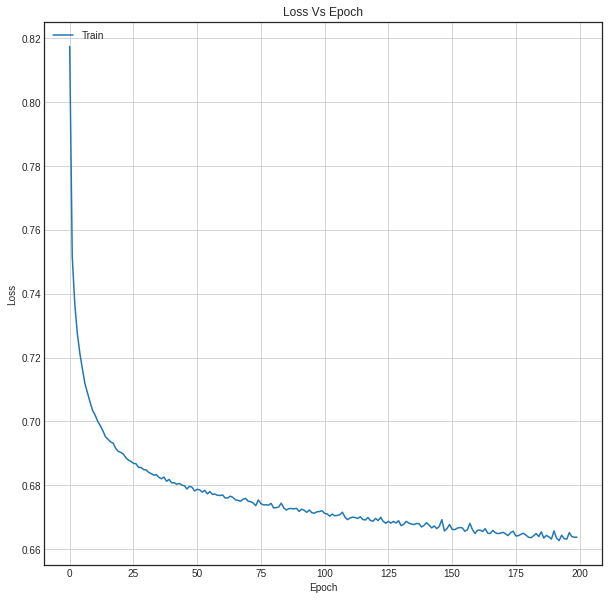

In [10]:
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(10, 10))
    #Plot training & validation loss values
    plt.plot([x for x in range(200)], history.history['loss'])
    plt.title('Loss Vs Epoch')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation', 'Test'], loc='upper left')
    plt.grid('on')
    #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.eps', format='eps')
    #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.svg', format='svg')
    #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.pdf', format='pdf') 
    plt.show() 

In [11]:
#save the trained model
model.save_weights('autoencoders_network.h5')

In [12]:
validation_size = 0.2
seed = 7
X_trainScaler, X_test_dev, Y_trainScaler, Y_test_dev = train_test_split(X_scaler, Y, test_size=validation_size, random_state=seed)
X_dev, X_test, Y_dev, Y_test = train_test_split(X_test_dev, Y_test_dev, test_size=0.5, random_state=seed)

encoder = Model(model.input, model.get_layer('encoder').output)
X_train_encoder = encoder.predict(X_trainScaler)  # bottleneck representation
X_dev_encoder = encoder.predict(X_dev) 
X_test_encoder = encoder.predict(X_test) 

In [15]:
#defining a classifier
def Nakano_Net(x_input):
    tf.keras.backend.clear_session()

    #Inputs
    inputs = tf.keras.Input(shape=(x_input,), name="input_1")
    #layer 1
    layers = tf.keras.layers.Dense(200,activation="relu",kernel_regularizer=regularizers.l1(0.0001),bias_regularizer=regularizers.l2(0.01))(inputs)
    layers = tf.keras.layers.Dropout(0.5)(layers)
    layers = tf.keras.layers.BatchNormalization(momentum=0.99, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    #layer 2
    layers = tf.keras.layers.Dense(200,activation="relu",kernel_regularizer=regularizers.l1(0.0001),bias_regularizer=regularizers.l2(0.01))(layers)
    layers = tf.keras.layers.Dropout(0.5)(layers)
    layers = tf.keras.layers.BatchNormalization(momentum=0.99, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    #layer 3
    layers = tf.keras.layers.Dense(200,activation="relu",kernel_regularizer=regularizers.l1(0.0001),bias_regularizer=regularizers.l2(0.01))(layers)
    layers = tf.keras.layers.Dropout(0.5)(layers)
    layers = tf.keras.layers.BatchNormalization(momentum=0.99, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    # layer 4
    predictions = tf.keras.layers.Dense(21, activation="softmax", name="output_1")(layers)
    # model generation
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    # optimizer
    opt = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08,)
    # loss function
    loss_fn = tf.keras.losses.CategoricalCrossentropy()
    # Compile model
    #model.compile(loss=loss_fn, optimizer=opt, metrics=['acc', 'AUC', 'mse','mae','mape'])
    model.compile(loss=loss_fn, optimizer=opt, metrics=[f1_m])
    return model

In [16]:
classifier = Nakano_Net(X_train_encoder.shape[1])
one_hot_labels_train = tf.keras.utils.to_categorical(Y_trainScaler, num_classes=21)
one_hot_labels_validation = tf.keras.utils.to_categorical(Y_dev, num_classes=21)
one_hot_labels_test = tf.keras.utils.to_categorical(Y_test, num_classes=21)

history=classifier.fit(X_train_encoder, one_hot_labels_train, epochs=200, 
                      batch_size=128,validation_data=(X_dev_encoder, one_hot_labels_validation),verbose=1)

Epoch 1/200
421/421 [==============================] - 2s 4ms/step - loss: 1.7817 - f1_m: 0.5628 - val_loss: 1.1450 - val_f1_m: 0.7558
Epoch 2/200
421/421 [==============================] - 2s 4ms/step - loss: 1.2278 - f1_m: 0.7170 - val_loss: 0.9542 - val_f1_m: 0.8130
Epoch 3/200
421/421 [==============================] - 2s 4ms/step - loss: 1.0707 - f1_m: 0.7556 - val_loss: 0.8361 - val_f1_m: 0.8402
Epoch 4/200
421/421 [==============================] - 2s 4ms/step - loss: 0.9697 - f1_m: 0.7734 - val_loss: 0.7552 - val_f1_m: 0.8513
Epoch 5/200
421/421 [==============================] - 1s 4ms/step - loss: 0.8978 - f1_m: 0.7884 - val_loss: 0.7084 - val_f1_m: 0.8590
Epoch 6/200
421/421 [==============================] - 2s 4ms/step - loss: 0.8618 - f1_m: 0.7934 - val_loss: 0.6774 - val_f1_m: 0.8589
Epoch 7/200
421/421 [==============================] - 2s 4ms/step - loss: 0.8329 - f1_m: 0.7986 - val_loss: 0.6519 - val_f1_m: 0.8669
Epoch 8/200
421/421 [==============================] - 

421/421 [==============================] - 1s 4ms/step - loss: 0.7384 - f1_m: 0.8334 - val_loss: 0.5843 - val_f1_m: 0.8909
Epoch 62/200
421/421 [==============================] - 2s 4ms/step - loss: 0.7425 - f1_m: 0.8317 - val_loss: 0.5850 - val_f1_m: 0.8919
Epoch 63/200
421/421 [==============================] - 2s 4ms/step - loss: 0.7378 - f1_m: 0.8338 - val_loss: 0.5821 - val_f1_m: 0.8910
Epoch 64/200
421/421 [==============================] - 2s 4ms/step - loss: 0.7373 - f1_m: 0.8320 - val_loss: 0.5727 - val_f1_m: 0.8944
Epoch 65/200
421/421 [==============================] - 2s 4ms/step - loss: 0.7368 - f1_m: 0.8328 - val_loss: 0.5922 - val_f1_m: 0.8875
Epoch 66/200
421/421 [==============================] - 2s 4ms/step - loss: 0.7415 - f1_m: 0.8312 - val_loss: 0.5767 - val_f1_m: 0.8922
Epoch 67/200
421/421 [==============================] - 1s 4ms/step - loss: 0.7348 - f1_m: 0.8336 - val_loss: 0.5859 - val_f1_m: 0.8894
Epoch 68/200
421/421 [==============================] - 1s 4m

Epoch 121/200
421/421 [==============================] - 1s 3ms/step - loss: 0.7335 - f1_m: 0.8352 - val_loss: 0.5749 - val_f1_m: 0.8959
Epoch 122/200
421/421 [==============================] - 2s 4ms/step - loss: 0.7308 - f1_m: 0.8366 - val_loss: 0.5706 - val_f1_m: 0.8964
Epoch 123/200
421/421 [==============================] - 2s 4ms/step - loss: 0.7325 - f1_m: 0.8357 - val_loss: 0.5709 - val_f1_m: 0.8994
Epoch 124/200
421/421 [==============================] - 1s 4ms/step - loss: 0.7385 - f1_m: 0.8356 - val_loss: 0.5836 - val_f1_m: 0.8899
Epoch 125/200
421/421 [==============================] - 2s 4ms/step - loss: 0.7379 - f1_m: 0.8344 - val_loss: 0.5706 - val_f1_m: 0.8968
Epoch 126/200
421/421 [==============================] - 1s 4ms/step - loss: 0.7352 - f1_m: 0.8346 - val_loss: 0.5756 - val_f1_m: 0.8963
Epoch 127/200
421/421 [==============================] - 1s 4ms/step - loss: 0.7310 - f1_m: 0.8355 - val_loss: 0.5802 - val_f1_m: 0.8907
Epoch 128/200
421/421 [==================

Epoch 181/200
421/421 [==============================] - 1s 4ms/step - loss: 0.7359 - f1_m: 0.8358 - val_loss: 0.5706 - val_f1_m: 0.8971
Epoch 182/200
421/421 [==============================] - 2s 4ms/step - loss: 0.7320 - f1_m: 0.8389 - val_loss: 0.5721 - val_f1_m: 0.8954
Epoch 183/200
421/421 [==============================] - 2s 4ms/step - loss: 0.7314 - f1_m: 0.8384 - val_loss: 0.5744 - val_f1_m: 0.8939
Epoch 184/200
421/421 [==============================] - 1s 4ms/step - loss: 0.7290 - f1_m: 0.8384 - val_loss: 0.5788 - val_f1_m: 0.8936
Epoch 185/200
421/421 [==============================] - 2s 4ms/step - loss: 0.7330 - f1_m: 0.8377 - val_loss: 0.5708 - val_f1_m: 0.8969
Epoch 186/200
421/421 [==============================] - 2s 4ms/step - loss: 0.7314 - f1_m: 0.8386 - val_loss: 0.5750 - val_f1_m: 0.8978
Epoch 187/200
421/421 [==============================] - 1s 4ms/step - loss: 0.7307 - f1_m: 0.8383 - val_loss: 0.5674 - val_f1_m: 0.8985
Epoch 188/200
421/421 [==================

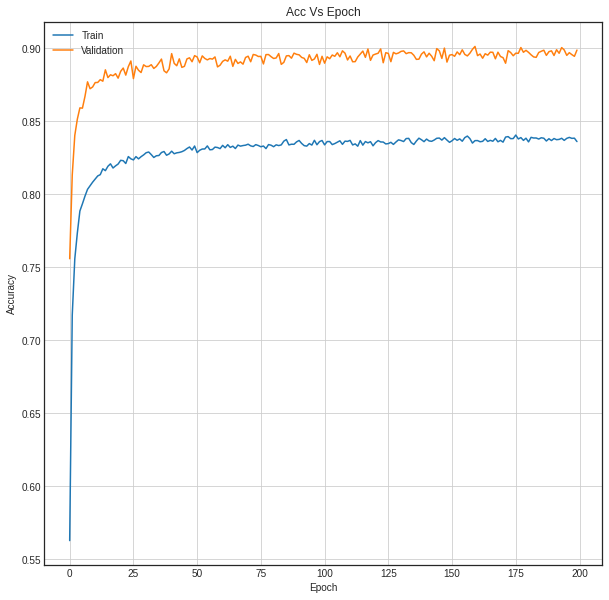

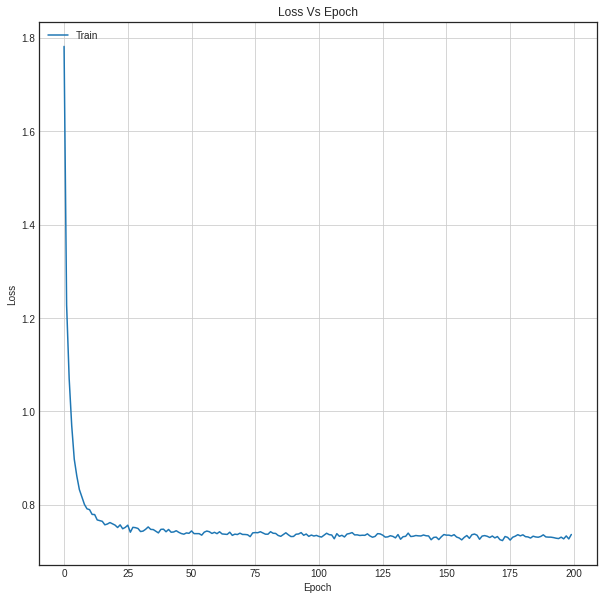

In [17]:
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(10, 10))
    #Plot training & validation loss values
    plt.plot([x for x in range(200)], history.history['f1_m'])
    plt.plot([x for x in range(200)], history.history['val_f1_m'])
    plt.title('Acc Vs Epoch')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation', 'Test'], loc='upper left')
    plt.grid('on')
    #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.eps', format='eps')
    #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.svg', format='svg')
    #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.pdf', format='pdf') 
    plt.show() 
    
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(10, 10))
    #Plot training & validation loss values
    plt.plot([x for x in range(200)], history.history['loss'])
    plt.title('Loss Vs Epoch')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation', 'Test'], loc='upper left')
    plt.grid('on')
    #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.eps', format='eps')
    #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.svg', format='svg')
    #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.pdf', format='pdf') 
    plt.show() 

Accuracy: 0.905214678353885
F1 score: 0.9029983603586097
Recall: 0.905214678353885
Precision: 0.9044736778460466

 clasification report:
               precision    recall  f1-score   support

           1       0.86      0.96      0.91      1220
           3       0.88      0.87      0.87       145
           4       0.91      0.94      0.92       166
           8       0.00      0.00      0.00         7
           9       0.79      0.85      0.82       319
          12       0.85      0.73      0.78       575
          13       0.89      0.90      0.89       325
          14       0.84      0.72      0.78       201
          16       0.88      0.50      0.64        58
          17       0.89      0.80      0.84       497
          18       0.97      0.94      0.95      1059
          19       0.87      0.88      0.88       372
          20       0.96      0.99      0.97      1787

    accuracy                           0.91      6731
   macro avg       0.81      0.78      0.79      6

/home/bioml/anaconda3/envs/tf22/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bioml/anaconda3/envs/tf22/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


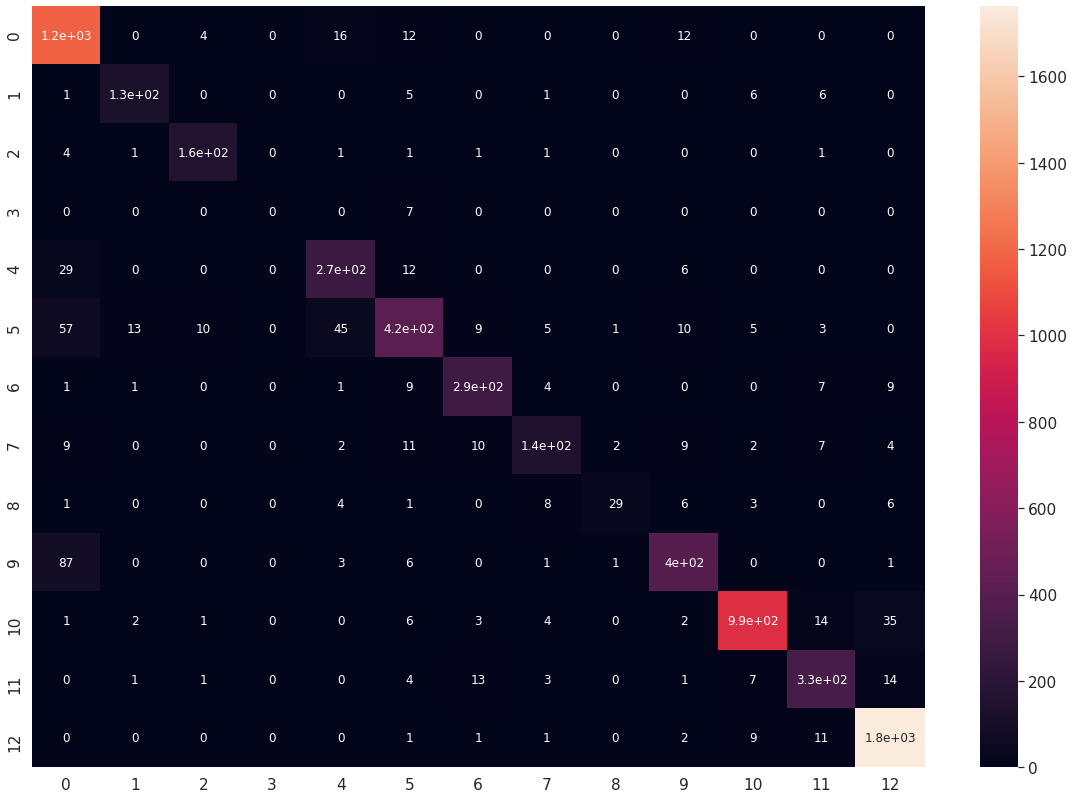

In [18]:
predictions = classifier.predict(X_test_encoder)

metrics(Y_test, [argmax(x) for x in predictions])

In [19]:
#comparing with PCA
pca = decomposition.PCA(n_components=256,svd_solver='full',tol=1e-4)
pca.fit(X_trainScaler)
X_trainPCAScaler = pca.transform(X_trainScaler)
X_validationPCAScaler = pca.transform(X_dev)
X_testPCAScaler = pca.transform(X_test)

In [22]:
classifier = Nakano_Net(X_trainPCAScaler.shape[1])

history=classifier.fit(X_trainPCAScaler, one_hot_labels_train, epochs=200, 
                      batch_size=128,validation_data=(X_validationPCAScaler, one_hot_labels_validation),verbose=1)

Epoch 1/200
421/421 [==============================] - 2s 4ms/step - loss: 1.7792 - f1_m: 0.6454 - val_loss: 0.9401 - val_f1_m: 0.9301
Epoch 2/200
421/421 [==============================] - 1s 4ms/step - loss: 0.9971 - f1_m: 0.8795 - val_loss: 0.7083 - val_f1_m: 0.9601
Epoch 3/200
421/421 [==============================] - 2s 4ms/step - loss: 0.7746 - f1_m: 0.9203 - val_loss: 0.5780 - val_f1_m: 0.9666
Epoch 4/200
421/421 [==============================] - 2s 4ms/step - loss: 0.6437 - f1_m: 0.9332 - val_loss: 0.4932 - val_f1_m: 0.9707
Epoch 5/200
421/421 [==============================] - 2s 4ms/step - loss: 0.5730 - f1_m: 0.9392 - val_loss: 0.4463 - val_f1_m: 0.9728
Epoch 6/200
421/421 [==============================] - 1s 3ms/step - loss: 0.5288 - f1_m: 0.9438 - val_loss: 0.4168 - val_f1_m: 0.9765
Epoch 7/200
421/421 [==============================] - 2s 4ms/step - loss: 0.5066 - f1_m: 0.9461 - val_loss: 0.4037 - val_f1_m: 0.9757
Epoch 8/200
421/421 [==============================] - 

421/421 [==============================] - 1s 4ms/step - loss: 0.4353 - f1_m: 0.9601 - val_loss: 0.3729 - val_f1_m: 0.9784
Epoch 62/200
421/421 [==============================] - 1s 4ms/step - loss: 0.4395 - f1_m: 0.9588 - val_loss: 0.3728 - val_f1_m: 0.9794
Epoch 63/200
421/421 [==============================] - 1s 4ms/step - loss: 0.4371 - f1_m: 0.9590 - val_loss: 0.3703 - val_f1_m: 0.9800
Epoch 64/200
421/421 [==============================] - 2s 4ms/step - loss: 0.4393 - f1_m: 0.9592 - val_loss: 0.3695 - val_f1_m: 0.9794
Epoch 65/200
421/421 [==============================] - 1s 4ms/step - loss: 0.4347 - f1_m: 0.9592 - val_loss: 0.3674 - val_f1_m: 0.9791
Epoch 66/200
421/421 [==============================] - 1s 3ms/step - loss: 0.4318 - f1_m: 0.9595 - val_loss: 0.3639 - val_f1_m: 0.9804
Epoch 67/200
421/421 [==============================] - 2s 4ms/step - loss: 0.4361 - f1_m: 0.9592 - val_loss: 0.3649 - val_f1_m: 0.9797
Epoch 68/200
421/421 [==============================] - 2s 4m

421/421 [==============================] - 1s 4ms/step - loss: 0.4393 - f1_m: 0.9596 - val_loss: 0.3675 - val_f1_m: 0.9805
Epoch 122/200
421/421 [==============================] - 2s 4ms/step - loss: 0.4373 - f1_m: 0.9597 - val_loss: 0.3661 - val_f1_m: 0.9809
Epoch 123/200
421/421 [==============================] - 1s 4ms/step - loss: 0.4304 - f1_m: 0.9603 - val_loss: 0.3671 - val_f1_m: 0.9795
Epoch 124/200
421/421 [==============================] - 2s 4ms/step - loss: 0.4368 - f1_m: 0.9590 - val_loss: 0.3673 - val_f1_m: 0.9815
Epoch 125/200
421/421 [==============================] - 1s 3ms/step - loss: 0.4353 - f1_m: 0.9603 - val_loss: 0.3607 - val_f1_m: 0.9810
Epoch 126/200
421/421 [==============================] - 1s 4ms/step - loss: 0.4347 - f1_m: 0.9591 - val_loss: 0.3691 - val_f1_m: 0.9794
Epoch 127/200
421/421 [==============================] - 1s 3ms/step - loss: 0.4357 - f1_m: 0.9601 - val_loss: 0.3747 - val_f1_m: 0.9767
Epoch 128/200
421/421 [==============================] 

Epoch 181/200
421/421 [==============================] - 2s 4ms/step - loss: 0.4344 - f1_m: 0.9599 - val_loss: 0.3693 - val_f1_m: 0.9797
Epoch 182/200
421/421 [==============================] - 1s 4ms/step - loss: 0.4318 - f1_m: 0.9614 - val_loss: 0.3641 - val_f1_m: 0.9808
Epoch 183/200
421/421 [==============================] - 2s 4ms/step - loss: 0.4338 - f1_m: 0.9608 - val_loss: 0.3712 - val_f1_m: 0.9793
Epoch 184/200
421/421 [==============================] - 2s 4ms/step - loss: 0.4366 - f1_m: 0.9596 - val_loss: 0.3742 - val_f1_m: 0.9774
Epoch 185/200
421/421 [==============================] - 2s 4ms/step - loss: 0.4353 - f1_m: 0.9603 - val_loss: 0.3685 - val_f1_m: 0.9794
Epoch 186/200
421/421 [==============================] - 2s 4ms/step - loss: 0.4310 - f1_m: 0.9598 - val_loss: 0.3676 - val_f1_m: 0.9788
Epoch 187/200
421/421 [==============================] - 1s 4ms/step - loss: 0.4326 - f1_m: 0.9601 - val_loss: 0.3597 - val_f1_m: 0.9813
Epoch 188/200
421/421 [==================

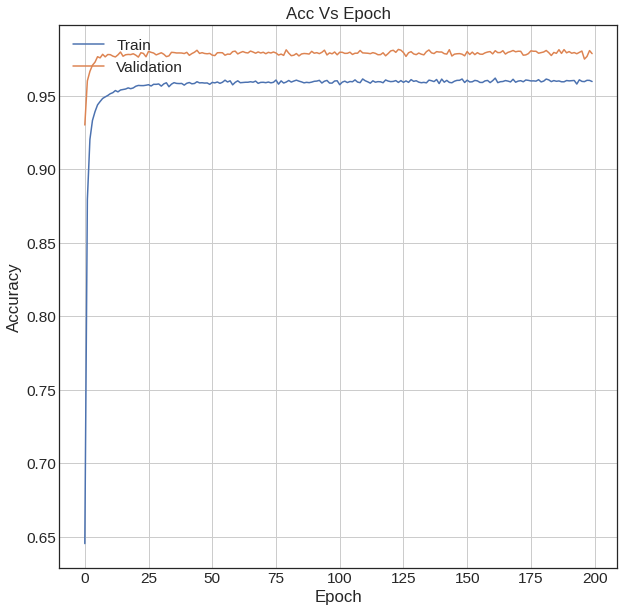

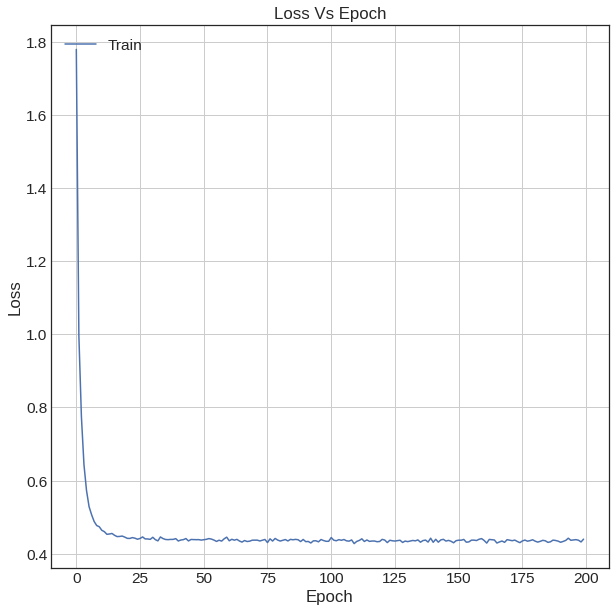

In [23]:
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(10, 10))
    #Plot training & validation loss values
    plt.plot([x for x in range(200)], history.history['f1_m'])
    plt.plot([x for x in range(200)], history.history['val_f1_m'])
    plt.title('Acc Vs Epoch')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation', 'Test'], loc='upper left')
    plt.grid('on')
    #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.eps', format='eps')
    #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.svg', format='svg')
    #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.pdf', format='pdf') 
    plt.show() 
    
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(10, 10))
    #Plot training & validation loss values
    plt.plot([x for x in range(200)], history.history['loss'])
    plt.title('Loss Vs Epoch')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation', 'Test'], loc='upper left')
    plt.grid('on')
    #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.eps', format='eps')
    #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.svg', format='svg')
    #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.pdf', format='pdf') 
    plt.show() 

Accuracy: 0.9826177388203833
F1 score: 0.9821101955591421
Recall: 0.9826177388203833
Precision: 0.9817206945992986

 clasification report:
               precision    recall  f1-score   support

           1       0.99      0.99      0.99      1220
           3       0.93      0.97      0.95       145
           4       1.00      0.99      1.00       166
           8       0.00      0.00      0.00         7
           9       0.95      0.98      0.96       319
          12       0.95      0.96      0.95       575
          13       1.00      0.98      0.99       325
          14       0.97      0.94      0.95       201
          16       0.98      0.90      0.94        58
          17       0.98      0.99      0.99       497
          18       0.99      0.99      0.99      1059
          19       0.98      0.99      0.98       372
          20       0.99      1.00      0.99      1787

    accuracy                           0.98      6731
   macro avg       0.90      0.90      0.90     

/home/bioml/anaconda3/envs/tf22/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bioml/anaconda3/envs/tf22/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


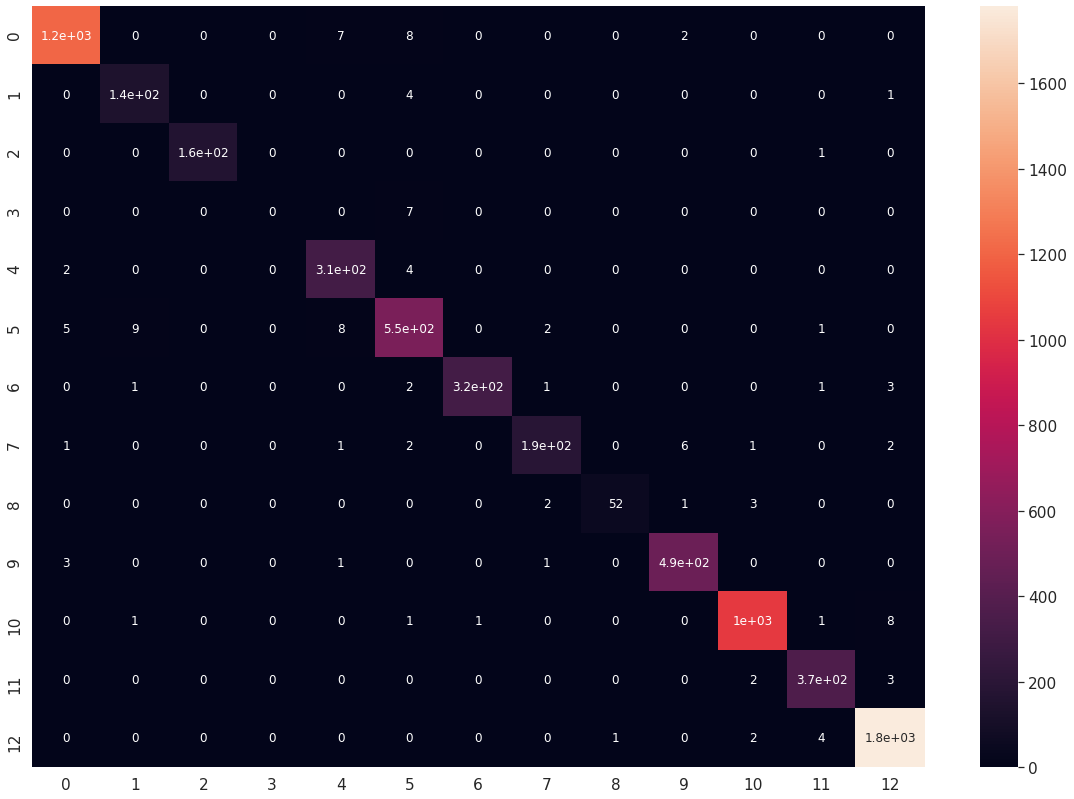

In [24]:
predictions = classifier.predict(X_testPCAScaler)

metrics(Y_test, [argmax(x) for x in predictions])

In [25]:
print(X_trainPCAScaler.shape)

(53844, 256)


In [26]:
print(X_train_encoder.shape)

(53844, 256)


In [27]:
# Initialize an empty array to hold feature importances
feature_importances = np.zeros(X_trainScaler.shape[1])

# Create the model with several hyperparameters
model = lgb.LGBMClassifier(objective='multiclass', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')

In [28]:
# Fit the model
    
# Train using early stopping
model.fit(X_trainScaler, Y_trainScaler, early_stopping_rounds=100, eval_set = [(X_dev, Y_dev)], eval_metric = 'multi_logloss', verbose = 1)

# Record the feature importances
feature_importances += model.feature_importances_

[1]	valid_0's multi_logloss: 2.21522
Training until validation scores don't improve for 100 rounds
[2]	valid_0's multi_logloss: 1.98082
[3]	valid_0's multi_logloss: 1.80285
[4]	valid_0's multi_logloss: 1.66021
[5]	valid_0's multi_logloss: 1.53881
[6]	valid_0's multi_logloss: 1.43281
[7]	valid_0's multi_logloss: 1.34139
[8]	valid_0's multi_logloss: 1.26145
[9]	valid_0's multi_logloss: 1.18868
[10]	valid_0's multi_logloss: 1.12369
[11]	valid_0's multi_logloss: 1.06638
[12]	valid_0's multi_logloss: 1.01391
[13]	valid_0's multi_logloss: 0.964999
[14]	valid_0's multi_logloss: 0.921776
[15]	valid_0's multi_logloss: 0.880944
[16]	valid_0's multi_logloss: 0.843584
[17]	valid_0's multi_logloss: 0.806228
[18]	valid_0's multi_logloss: 0.773241
[19]	valid_0's multi_logloss: 0.742121
[20]	valid_0's multi_logloss: 0.713842
[21]	valid_0's multi_logloss: 0.687108
[22]	valid_0's multi_logloss: 0.662938
[23]	valid_0's multi_logloss: 0.640054
[24]	valid_0's multi_logloss: 0.618745
[25]	valid_0's multi_lo

[208]	valid_0's multi_logloss: 0.0998367
[209]	valid_0's multi_logloss: 0.0997065
[210]	valid_0's multi_logloss: 0.0995011
[211]	valid_0's multi_logloss: 0.0994058
[212]	valid_0's multi_logloss: 0.0992356
[213]	valid_0's multi_logloss: 0.099179
[214]	valid_0's multi_logloss: 0.0990416
[215]	valid_0's multi_logloss: 0.0989478
[216]	valid_0's multi_logloss: 0.098958
[217]	valid_0's multi_logloss: 0.0988434
[218]	valid_0's multi_logloss: 0.0987835
[219]	valid_0's multi_logloss: 0.0986257
[220]	valid_0's multi_logloss: 0.0985697
[221]	valid_0's multi_logloss: 0.0983357
[222]	valid_0's multi_logloss: 0.0982269
[223]	valid_0's multi_logloss: 0.0980341
[224]	valid_0's multi_logloss: 0.0979104
[225]	valid_0's multi_logloss: 0.0978407
[226]	valid_0's multi_logloss: 0.097781
[227]	valid_0's multi_logloss: 0.0975826
[228]	valid_0's multi_logloss: 0.0975354
[229]	valid_0's multi_logloss: 0.0974387
[230]	valid_0's multi_logloss: 0.0973364
[231]	valid_0's multi_logloss: 0.0972318
[232]	valid_0's mul

[409]	valid_0's multi_logloss: 0.0940133
[410]	valid_0's multi_logloss: 0.0939385
[411]	valid_0's multi_logloss: 0.0940376
[412]	valid_0's multi_logloss: 0.0939694
[413]	valid_0's multi_logloss: 0.0939567
[414]	valid_0's multi_logloss: 0.0939432
[415]	valid_0's multi_logloss: 0.0938794
[416]	valid_0's multi_logloss: 0.0937842
[417]	valid_0's multi_logloss: 0.0936087
[418]	valid_0's multi_logloss: 0.0935611
[419]	valid_0's multi_logloss: 0.0935099
[420]	valid_0's multi_logloss: 0.0934212
[421]	valid_0's multi_logloss: 0.093431
[422]	valid_0's multi_logloss: 0.0933496
[423]	valid_0's multi_logloss: 0.0932727
[424]	valid_0's multi_logloss: 0.0933306
[425]	valid_0's multi_logloss: 0.093282
[426]	valid_0's multi_logloss: 0.0933583
[427]	valid_0's multi_logloss: 0.0934099
[428]	valid_0's multi_logloss: 0.0933437
[429]	valid_0's multi_logloss: 0.0933125
[430]	valid_0's multi_logloss: 0.0932603
[431]	valid_0's multi_logloss: 0.0932059
[432]	valid_0's multi_logloss: 0.0933066
[433]	valid_0's mu

In [29]:
model.score(X_test, Y_test)

0.979646412123013

In [30]:
print(training.drop(['Label'], axis=1).columns)

print(len(feature_importances))

Index(['A', 'C', 'G', 'T', 'AA', 'AC', 'AG', 'AT', 'CA', 'CC',
       ...
       'TTTTCG', 'TTTTCT', 'TTTTGA', 'TTTTGC', 'TTTTGG', 'TTTTGT', 'TTTTTA',
       'TTTTTC', 'TTTTTG', 'TTTTTT'],
      dtype='object', length=5460)
5460


In [31]:
# Make sure to average feature importances! 
feature_importances = feature_importances / 2
feature_importances = pd.DataFrame({'feature': list(training.drop(['Label'], axis=1).columns), 'importance': feature_importances}).sort_values('importance', ascending = False)

In [32]:
print(feature_importances)
type(feature_importances)

     feature  importance
0          A       234.5
3          T       222.5
2046  AGGGGG       185.5
2731  CCCCCT       169.0
161     CATC       163.5
...      ...         ...
1774  ACGCGG         0.0
3806  GCGAGG         0.0
2221  ATCCGC         0.0
1662  ACAGGG         0.0
3438  GAACGG         0.0

[5460 rows x 2 columns]


pandas.core.frame.DataFrame

A 234.5
T 222.5
AGGGGG 185.5
CCCCCT 169.0
CATC 163.5
ACATA 161.5
TATGT 160.0
AGCT 157.0
CCTT 155.5
ATAT 152.5
AAGG 147.5
C 142.5
G 139.5
AAAAAA 137.5
GATGA 133.0
TTTTTT 132.5
CTT 128.0
ACAT 126.5
AGA 125.5
ATATA 125.5
ATGT 122.5
AAG 122.5
TGG 121.0
TTAA 115.5
TTC 115.5
GATC 115.0
TATAT 114.5
CTAG 113.0
GAA 112.5
CCA 110.5
CTTT 107.5
GAAG 107.0
CCAAT 106.5
TCTC 106.0
GTAC 106.0
CTTG 105.5
GAGA 105.5
TATG 105.5
CCTTT 104.5
GGGGGA 104.5
TAAC 102.0
TGCC 99.5
CCAT 99.0
AAAGG 98.5
TCCCCC 98.5
TCATC 98.0
GATG 97.0
GGCC 96.5
TGTA 96.0
AAGC 95.0
TACC 93.0
GGGGAG 92.0
CTTC 91.5
TTAAT 89.5
GATTGG 89.0
AACTC 89.0
AATC 88.0
GAGTT 88.0
GA 87.5
TTGGC 87.0
AAAAA 86.5
CATGT 86.5
TGCA 86.5
TGGGGG 86.5
TCT 86.0
GCTTG 85.5
TTGA 85.0
GTTA 85.0
AAAG 84.5
TCAA 83.0
CATA 83.0
CATTA 82.0
CTTTT 82.0
GCT 82.0
CCAATC 81.5
TACAT 81.5
TCTTC 81.0
GTAG 81.0
ATGG 81.0
TACA 79.5
GGTGG 79.0
GTAA 79.0
GAAT 79.0
TACT 78.5
ATTGG 78.5
ATGTAT 78.0
AACT 77.0
TATA 76.5
TCGA 76.5
GAATC 76.5
TTAC 76.5
ATATC 76.0
GAATT 76.0
GTTAT

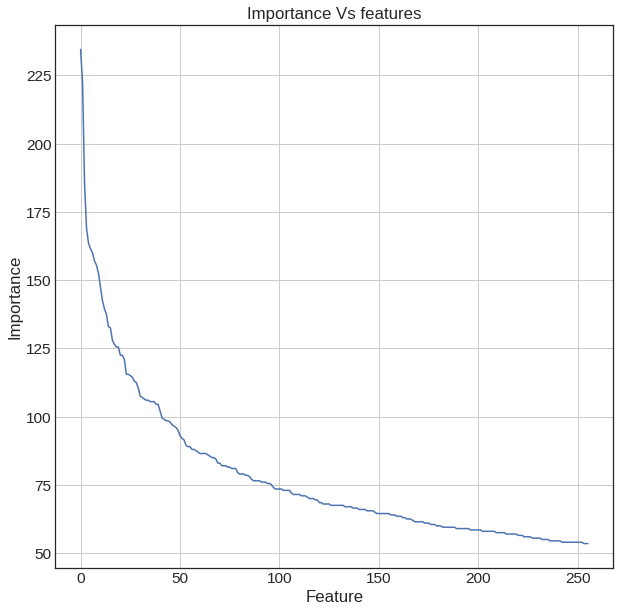

In [33]:
i = 0
importances = []
features = []
for imp in feature_importances['importance']:
    if imp > 0:
        print(list(feature_importances['feature'])[i]+" "+str(imp))
        importances.append(imp)
        features.append(list(feature_importances['feature'])[i])
    i += 1
    if len(importances) == 256:
        break
    
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(10, 10))
    #Plot training & validation loss values
    plt.plot([x for x in range(len(importances))], importances)
    plt.title('Importance Vs features')
    plt.ylabel('Importance')
    plt.xlabel('Feature')
    plt.grid('on')
    #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.eps', format='eps')
    #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.svg', format='svg')
    #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.pdf', format='pdf') 
    plt.show() 

In [34]:
print(','.join(features))

A,T,AGGGGG,CCCCCT,CATC,ACATA,TATGT,AGCT,CCTT,ATAT,AAGG,C,G,AAAAAA,GATGA,TTTTTT,CTT,ACAT,AGA,ATATA,ATGT,AAG,TGG,TTAA,TTC,GATC,TATAT,CTAG,GAA,CCA,CTTT,GAAG,CCAAT,TCTC,GTAC,CTTG,GAGA,TATG,CCTTT,GGGGGA,TAAC,TGCC,CCAT,AAAGG,TCCCCC,TCATC,GATG,GGCC,TGTA,AAGC,TACC,GGGGAG,CTTC,TTAAT,GATTGG,AACTC,AATC,GAGTT,GA,TTGGC,AAAAA,CATGT,TGCA,TGGGGG,TCT,GCTTG,TTGA,GTTA,AAAG,TCAA,CATA,CATTA,CTTTT,GCT,CCAATC,TACAT,TCTTC,GTAG,ATGG,TACA,GGTGG,GTAA,GAAT,TACT,ATTGG,ATGTAT,AACT,TATA,TCGA,GAATC,TTAC,ATATC,GAATT,GTTATG,CAAG,GCTT,TCAAA,CTTGT,TAC,AAGCA,GGC,ACCC,ATGTA,ATC,GCC,CTCCCC,TGTG,AGAT,ACGT,TTTGA,TGAAG,TA,CCCCCA,TC,AT,GAT,GGTG,CTAC,GTA,CCAAAA,TCATCA,GAAAG,GCCAA,GATATG,CCATG,CCGG,AGGG,GACT,CCAA,CTC,GGTA,ACTG,AGTC,AGAGAG,AATTC,CAG,ATTAAT,TGCTT,TCTG,ACATG,GGCCA,GGCA,AGAA,ATTC,GAAGA,TGGGG,CCAC,TTTTGG,AAGTC,AGTT,TGGCC,AAACA,CCGA,GGGTA,ATCA,CATT,GCAT,CAGT,TTATG,GGTTTT,CATAA,AAGAA,CATG,GGGT,AAAGA,AGATAT,CAAAG,AATTG,CCCT,TTGGCC,CATAAC,ACAAG,GATAT,GATT,TCTTG,AATGC,CC,GTGT,ACCATG,TATGG,TTGAG,ATATG,GCTTGG,GCATT,TTGCT,TTC

In [35]:
training_reduced = training.loc[:, ['Label','A','T','AGGGGG','CCCCCT','CATC','ACATA','TATGT','AGCT','CCTT','ATAT','AAGG','C','G','AAAAAA','GATGA','TTTTTT','CTT','ACAT','AGA','ATATA','ATGT','AAG','TGG','TTAA','TTC','GATC','TATAT','CTAG','GAA','CCA','CTTT','GAAG','CCAAT','TCTC','GTAC','CTTG','GAGA','TATG','CCTTT','GGGGGA','TAAC','TGCC','CCAT','AAAGG','TCCCCC','TCATC','GATG','GGCC','TGTA','AAGC','TACC','GGGGAG','CTTC','TTAAT','GATTGG','AACTC','AATC','GAGTT','GA','TTGGC','AAAAA','CATGT','TGCA','TGGGGG','TCT','GCTTG','TTGA','GTTA','AAAG','TCAA','CATA','CATTA','CTTTT','GCT','CCAATC','TACAT','TCTTC','GTAG','ATGG','TACA','GGTGG','GTAA','GAAT','TACT','ATTGG','ATGTAT','AACT','TATA','TCGA','GAATC','TTAC','ATATC','GAATT','GTTATG','CAAG','GCTT','TCAAA','CTTGT','TAC','AAGCA','GGC','ACCC','ATGTA','ATC','GCC','CTCCCC','TGTG','AGAT','ACGT','TTTGA','TGAAG','TA','CCCCCA','TC','AT','GAT','GGTG','CTAC','GTA','CCAAAA','TCATCA','GAAAG','GCCAA','GATATG','CCATG','CCGG','AGGG','GACT','CCAA','CTC','GGTA','ACTG','AGTC','AGAGAG','AATTC','CAG','ATTAAT','TGCTT','TCTG','ACATG','GGCCA','GGCA','AGAA','ATTC','GAAGA','TGGGG','CCAC','TTTTGG','AAGTC','AGTT','TGGCC','AAACA','CCGA','GGGTA','ATCA','CATT','GCAT','CAGT','TTATG','GGTTTT','CATAA','AAGAA','CATG','GGGT','AAAGA','AGATAT','CAAAG','AATTG','CCCT','TTGGCC','CATAAC','ACAAG','GATAT','GATT','TCTTG','AATGC','CC','GTGT','ACCATG','TATGG','TTGAG','ATATG','GCTTGG','GCATT','TTGCT','TTCTT','TTTGAA','GAAATG','TAT','CTTTG','TACATG','AG','ATGC','TTTCTT','TAGG','CATTG','CATATG','AAAAG','TGGCCA','AGTGGG','AGAC','CTTAA','ATTG','GGG','CTTCA','CCACC','GAG','TGT','CATATC','GGAG','TATATG','GCAC','CACA','TGGTA','TCTCTC','CATGG','ATAC','CTG','TGTTT','ACTTG','GGTAA','CAGA','CCC','GGGG','AGTA','ACT','ATCT','GC','GTTG','CTGG','GACTT','GAGAG','CTTTTT','AGT','TCG','TGAT','TGTAT','TGTGT','GCATC','TGATGC','AAAAAG','AAGT','CTAAG','CATTTC','GCCTT','TTGG','TCCCC','ACAC','GCTAT','CCCCC','TTTT','CAAGA','TCGG','ATAAT','TACCC','CCCC']]
Y_reduced = training_reduced['Label'].values
X_reduced = training_reduced.drop(['Label'], axis=1).values

scaler_reduced = preprocessing.StandardScaler().fit(X_reduced)
X_reduced_scaler = scaler_reduced.transform(X_reduced)

validation_size = 0.2
seed = 7
X_trainScaler_reduced, X_test_dev_reduced, Y_trainScaler_reduced, Y_test_dev_reduced = train_test_split(X_reduced_scaler, Y_reduced, test_size=validation_size, random_state=seed)
X_dev_reduced, X_test_reduced, Y_dev_reduced, Y_test_reduced = train_test_split(X_test_dev_reduced, Y_test_dev_reduced, test_size=0.5, random_state=seed)

one_hot_labels_train_r = tf.keras.utils.to_categorical(Y_trainScaler_reduced, num_classes=21)
one_hot_labels_validation_r = tf.keras.utils.to_categorical(Y_dev_reduced, num_classes=21)
one_hot_labels_test_r = tf.keras.utils.to_categorical(Y_test_reduced, num_classes=21)


In [36]:
print(X_reduced.shape)
print(Y_reduced.shape)

(67305, 256)
(67305,)


In [37]:
classifier = Nakano_Net(X_trainScaler_reduced.shape[1])

history=classifier.fit(X_trainScaler_reduced, one_hot_labels_train_r, epochs=200, 
                      batch_size=128,validation_data=(X_dev_reduced, one_hot_labels_validation_r),verbose=1)

Epoch 1/200
421/421 [==============================] - 2s 4ms/step - loss: 1.7827 - f1_m: 0.6441 - val_loss: 1.0755 - val_f1_m: 0.8811
Epoch 2/200
421/421 [==============================] - 2s 4ms/step - loss: 1.1695 - f1_m: 0.8234 - val_loss: 0.8524 - val_f1_m: 0.9171
Epoch 3/200
421/421 [==============================] - 2s 4ms/step - loss: 0.9639 - f1_m: 0.8619 - val_loss: 0.7056 - val_f1_m: 0.9386
Epoch 4/200
421/421 [==============================] - 1s 4ms/step - loss: 0.8388 - f1_m: 0.8791 - val_loss: 0.6318 - val_f1_m: 0.9396
Epoch 5/200
421/421 [==============================] - 1s 4ms/step - loss: 0.7544 - f1_m: 0.8900 - val_loss: 0.6068 - val_f1_m: 0.9336
Epoch 6/200
421/421 [==============================] - 2s 4ms/step - loss: 0.7104 - f1_m: 0.8956 - val_loss: 0.5315 - val_f1_m: 0.9489
Epoch 7/200
421/421 [==============================] - 1s 4ms/step - loss: 0.6783 - f1_m: 0.8981 - val_loss: 0.5166 - val_f1_m: 0.9456
Epoch 8/200
421/421 [==============================] - 

421/421 [==============================] - 1s 4ms/step - loss: 0.5670 - f1_m: 0.9221 - val_loss: 0.4460 - val_f1_m: 0.9585
Epoch 62/200
421/421 [==============================] - 2s 4ms/step - loss: 0.5604 - f1_m: 0.9225 - val_loss: 0.4296 - val_f1_m: 0.9630
Epoch 63/200
421/421 [==============================] - 1s 4ms/step - loss: 0.5676 - f1_m: 0.9213 - val_loss: 0.4487 - val_f1_m: 0.9563
Epoch 64/200
421/421 [==============================] - 1s 4ms/step - loss: 0.5672 - f1_m: 0.9222 - val_loss: 0.4531 - val_f1_m: 0.9576
Epoch 65/200
421/421 [==============================] - 1s 4ms/step - loss: 0.5678 - f1_m: 0.9218 - val_loss: 0.4481 - val_f1_m: 0.9624
Epoch 66/200
421/421 [==============================] - 1s 3ms/step - loss: 0.5674 - f1_m: 0.9205 - val_loss: 0.4524 - val_f1_m: 0.9585
Epoch 67/200
421/421 [==============================] - 2s 4ms/step - loss: 0.5688 - f1_m: 0.9215 - val_loss: 0.4563 - val_f1_m: 0.9582
Epoch 68/200
421/421 [==============================] - 2s 4m

421/421 [==============================] - 1s 4ms/step - loss: 0.5627 - f1_m: 0.9233 - val_loss: 0.4460 - val_f1_m: 0.9604
Epoch 122/200
421/421 [==============================] - 1s 4ms/step - loss: 0.5681 - f1_m: 0.9224 - val_loss: 0.4476 - val_f1_m: 0.9592
Epoch 123/200
421/421 [==============================] - 1s 4ms/step - loss: 0.5680 - f1_m: 0.9230 - val_loss: 0.4419 - val_f1_m: 0.9609
Epoch 124/200
421/421 [==============================] - 1s 4ms/step - loss: 0.5587 - f1_m: 0.9242 - val_loss: 0.4336 - val_f1_m: 0.9631
Epoch 125/200
421/421 [==============================] - 2s 4ms/step - loss: 0.5623 - f1_m: 0.9246 - val_loss: 0.4409 - val_f1_m: 0.9623
Epoch 126/200
421/421 [==============================] - 1s 4ms/step - loss: 0.5658 - f1_m: 0.9225 - val_loss: 0.4474 - val_f1_m: 0.9602
Epoch 127/200
421/421 [==============================] - 1s 4ms/step - loss: 0.5649 - f1_m: 0.9225 - val_loss: 0.4380 - val_f1_m: 0.9632
Epoch 128/200
421/421 [==============================] 

Epoch 181/200
421/421 [==============================] - 1s 4ms/step - loss: 0.5606 - f1_m: 0.9242 - val_loss: 0.4429 - val_f1_m: 0.9621
Epoch 182/200
421/421 [==============================] - 1s 3ms/step - loss: 0.5643 - f1_m: 0.9245 - val_loss: 0.4420 - val_f1_m: 0.9604
Epoch 183/200
421/421 [==============================] - 2s 4ms/step - loss: 0.5655 - f1_m: 0.9242 - val_loss: 0.4588 - val_f1_m: 0.9554
Epoch 184/200
421/421 [==============================] - 2s 4ms/step - loss: 0.5691 - f1_m: 0.9225 - val_loss: 0.4486 - val_f1_m: 0.9585
Epoch 185/200
421/421 [==============================] - 1s 4ms/step - loss: 0.5608 - f1_m: 0.9247 - val_loss: 0.4385 - val_f1_m: 0.9635
Epoch 186/200
421/421 [==============================] - 2s 4ms/step - loss: 0.5631 - f1_m: 0.9236 - val_loss: 0.4546 - val_f1_m: 0.9600
Epoch 187/200
421/421 [==============================] - 1s 4ms/step - loss: 0.5639 - f1_m: 0.9239 - val_loss: 0.4382 - val_f1_m: 0.9628
Epoch 188/200
421/421 [==================

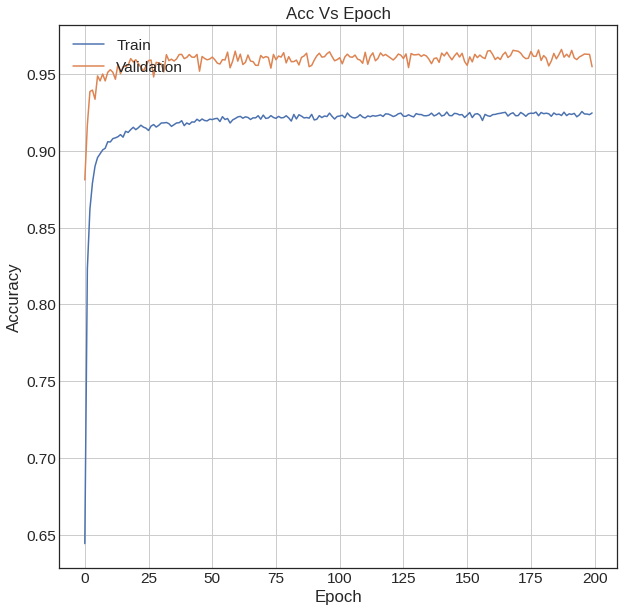

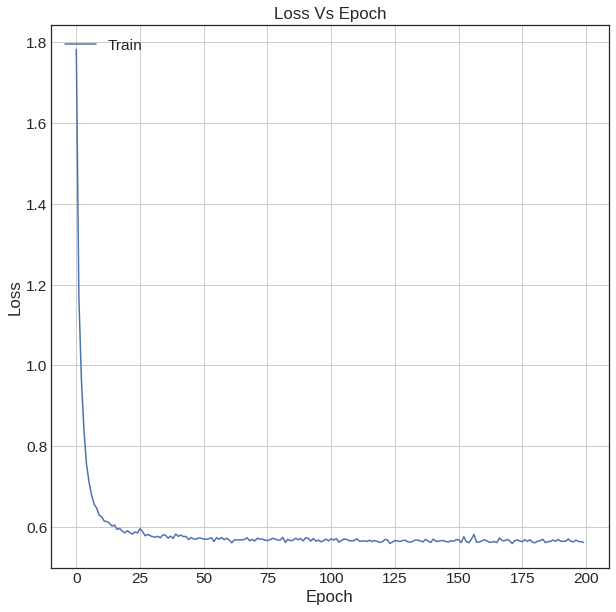

In [38]:
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(10, 10))
    #Plot training & validation loss values
    plt.plot([x for x in range(200)], history.history['f1_m'])
    plt.plot([x for x in range(200)], history.history['val_f1_m'])
    plt.title('Acc Vs Epoch')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation', 'Test'], loc='upper left')
    plt.grid('on')
    #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.eps', format='eps')
    #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.svg', format='svg')
    #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.pdf', format='pdf') 
    plt.show() 
    
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(10, 10))
    #Plot training & validation loss values
    plt.plot([x for x in range(200)], history.history['loss'])
    plt.title('Loss Vs Epoch')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation', 'Test'], loc='upper left')
    plt.grid('on')
    #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.eps', format='eps')
    #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.svg', format='svg')
    #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.pdf', format='pdf') 
    plt.show() 

Accuracy: 0.956172931213787
F1 score: 0.9555487517331525
Recall: 0.956172931213787
Precision: 0.956123158621343

 clasification report:
               precision    recall  f1-score   support

           1       0.99      0.96      0.97      1220
           3       0.94      0.88      0.91       145
           4       0.99      0.89      0.93       166
           8       0.00      0.00      0.00         7
           9       0.91      0.97      0.94       319
          12       0.89      0.94      0.92       575
          13       1.00      0.93      0.96       325
          14       0.95      0.84      0.89       201
          16       0.86      0.84      0.85        58
          17       0.93      0.99      0.96       497
          18       0.97      0.95      0.96      1059
          19       0.97      0.93      0.95       372
          20       0.96      1.00      0.98      1787

    accuracy                           0.96      6731
   macro avg       0.87      0.85      0.86      67

/home/bioml/anaconda3/envs/tf22/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bioml/anaconda3/envs/tf22/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


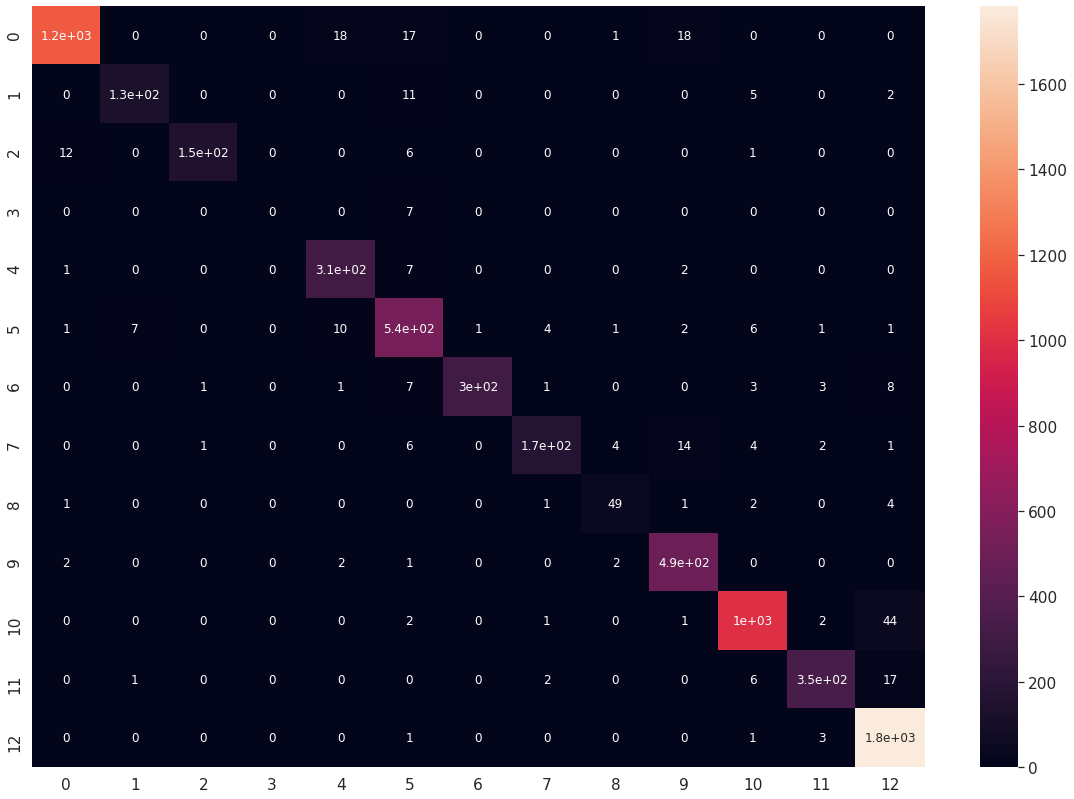

In [40]:
predictions = classifier.predict(X_test_reduced)

metrics(Y_test_reduced, [argmax(x) for x in predictions])